# Importing Header and SoilPrep

In [1]:
import import_ipynb 
from Header import *

importing Jupyter notebook from Header.ipynb


In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 0: Setting up decision parameters (Data Tree)

In [3]:
# 0. Available smoothing filter types: savgol1 and savgol2 ------------------------ (0)
sg_filters = ['sg1', 'sg2']

# 0. Available window lengths for the smoothing filter ---------------------------- (0)
window_lengths = [0, 1, 11, 21, 31, 41, 51]

# 1. Available machine learning regression models --------------------------------- (1)
ml_methods = ['mult', 'cubist', 'svr',  'ridge', 'plsr', 'randomforest',  'gbrt']

# 2. Names of target variables in the dataframe ----------------------------------- (2)
target_names = ['Sand', 'Silt', 'Clay', 'TOC']

# 3. Available preprocessing for Target data -------------------------------------- (3)
prepare_target = ['none']
# 4. Available preprocessing for Spectral data ------------------------------------ (4)
prepare_spec = ['none', 'fod', 'cr', 'log', 'fod_cr', 'fod_log']
# 5. Resampling bands available for spectra --------------------------------------- (5) 
nbands_sampling = [0,2,3,5,7,9,10,11,13,15,17,19,20,21,23,25,27,29,30,31,33,35,37,39, 40, 45, 50, 55, 60, 70, 80, 90, 100]


# Setting colours for different targets        --------------------------------------
clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [4]:
MetaData = {'sg_filters' : sg_filters, 'window_lengths' : window_lengths, 'prepare_spec' : prepare_spec, \
            'nbands_sampling' : nbands_sampling, 'target_names' : target_names, 'prepare_target' : prepare_target,\
            'ml_methods' : ml_methods, 'clr' : clr}

with open ('meta_data.pickle', 'wb') as file:
    pickle.dump(MetaData, file)

# Step 1a: Obtaining Spectra

In [5]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [6]:
#----------- Reading lab data and Sentinel data -----------------------------
df_lab = pd.read_csv('uae.csv')
df_sat = pd.read_csv('UAE_Soil_Samples.csv')

#-------------Renaming columns---------------------------------------------------------------------------
df_sat.rename(columns= {'Lon':'long', 'Lat': 'lat'}, inplace=True)
df_lab.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)

In [7]:
#----------- Obtaining targets from UAE Lab-----------------------
df_target = df_lab.iloc[:,0:7].copy()

In [8]:
df_target.head(2)

FID       long        lat   TOC  clay  silt   sand
0    1  54.736553  24.236353  0.22     0   1.0   98.0
1    2  54.712263  24.253125  0.23     0   0.0  100.0

In [9]:
df_target.shape

(294, 7)

In [10]:
#---------------- Function to interchange long and lat columns in df_sat in order to merge df_sat and df_target--------------

def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

#swap points and rebounds columns
df_sat = swap_columns(df_sat, 'long', 'lat')

#view updated DataFrame
#print(df_sat)

In [11]:
#-------------- Preparing the dataset with target and spectra to buld models---------------

result = df_target.merge(df_sat, left_on=['long', 'lat', 'FID'], right_on=['long', 'lat', 'FID'])

In [12]:
result

FID       long        lat   TOC  clay  silt   sand      B2      B3  \
0      1  54.736553  24.236353  0.22     0   1.0   98.0  0.1983  0.2669   
1      2  54.712263  24.253125  0.23     0   0.0  100.0  0.1266  0.1748   
2      3  54.628437  24.201236  0.54     7   2.0   71.0  0.1337  0.1808   
3      4  54.637328  24.167353  0.06     0   1.0   74.0  0.1900  0.2318   
4      5  54.871967  24.194968  5.97     0   1.0   94.0  0.1710  0.2360   
..   ...        ...        ...   ...   ...   ...    ...     ...     ...   
204  182  55.605843  24.689525  0.29     0   2.0   98.0  0.1440  0.2026   
205  184  55.757064  24.567733  0.64     0   1.0   91.0  0.1040  0.1556   
206  185  55.758205  24.566327  1.64     0   1.0   95.0  0.1218  0.1750   
207  188  55.779780  24.440850  1.58     0   3.0   96.0  0.0955  0.1396   
208  189  55.773787  24.281881  1.66     0   6.0   89.0  0.0663  0.0938   

         B4      B5      B6      B7      B8     B8A     B11     B12  
0    0.3461  0.4096  0.4312  0.4498  0.4450  0.4641  0.5515  0.5029  
1    0.2022  0.2686  0.3564  0.3943  0.4136  0.4193  0.4070  0.3293  
2    0.2285  0.2577  0.2567  0.2690  0.2606  0.2737  0.3505  0.3154  
3    0.2706  0.3033  0.2985  0.3049  0.2884  0.3007  0.3809  0.3385  
4    0.3192  0.3894  0.3999  0.4249  0.4356  0.4538  0.5743  0.4974  
..      ...     ...     ...     ...     ...     ...     ...     ...  
204  0.2718  0.3032  0.3452  0.3798  0.3898  0.3981  0.4386  0.3794  
205  0.2146  0.2511  0.3201  0.3511  0.3602  0.3722  0.3880  0.3316  
206  0.2624  0.2971  0.3193  0.3485  0.3805  0.3962  0.4967  0.3909  
207  0.1494  0.2058  0.3100  0.3442  0.3520  0.3602  0.3104  0.2375  
208  0.0879  0.1279  0.2516  0.3321  0.3368  0.3540  0.1705  0.1082  

[209 rows x 17 columns]

In [13]:
type(result)

pandas.core.frame.DataFrame

In [14]:
spectra = result.iloc[:, 7:17].copy()
spectra.head(5)

B2      B3      B4      B5      B6      B7      B8     B8A     B11  \
0  0.1983  0.2669  0.3461  0.4096  0.4312  0.4498  0.4450  0.4641  0.5515   
1  0.1266  0.1748  0.2022  0.2686  0.3564  0.3943  0.4136  0.4193  0.4070   
2  0.1337  0.1808  0.2285  0.2577  0.2567  0.2690  0.2606  0.2737  0.3505   
3  0.1900  0.2318  0.2706  0.3033  0.2985  0.3049  0.2884  0.3007  0.3809   
4  0.1710  0.2360  0.3192  0.3894  0.3999  0.4249  0.4356  0.4538  0.5743   

      B12  
0  0.5029  
1  0.3293  
2  0.3154  
3  0.3385  
4  0.4974

In [15]:
spectra.shape

(209, 10)

# Step 1b: Obtaining Targets 

In [16]:
#df = pd.read_csv('uae.csv')
result.rename(columns = {'clay':'Clay', 'silt': 'Silt', 'sand': 'Sand'}, inplace = True)
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(result, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(result[target_names[i]])
    return(T)
    
T = isolate_targets(result,target_names)

In [17]:
T

[0       98.0
 1      100.0
 2       71.0
 3       74.0
 4       94.0
        ...  
 204     98.0
 205     91.0
 206     95.0
 207     96.0
 208     89.0
 Name: Sand, Length: 209, dtype: float64,
 0      1.0
 1      0.0
 2      2.0
 3      1.0
 4      1.0
       ... 
 204    2.0
 205    1.0
 206    1.0
 207    3.0
 208    6.0
 Name: Silt, Length: 209, dtype: float64,
 0      0
 1      0
 2      7
 3      0
 4      0
       ..
 204    0
 205    0
 206    0
 207    0
 208    0
 Name: Clay, Length: 209, dtype: int64,
 0      0.22
 1      0.23
 2      0.54
 3      0.06
 4      5.97
        ... 
 204    0.29
 205    0.64
 206    1.64
 207    1.58
 208    1.66
 Name: TOC, Length: 209, dtype: float64]

# Step 1c: Spectra Preprocessing (Smooth, FOD/Contin/Log , and Resample)

## Savgol smoothing (order 1 and order 2)

In [18]:
# # -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

# spec1 = {}
# for i in window_lengths:
#     spec1[i] = filt_sg(spectra, i, 'sg1')                   

# spec2 = {}
# for i in window_lengths:
#spec2[51] = filt_sg(spectra, 51, 'sg2')

# smth_spec = sgsmooth (spectra, 3)    

In [19]:
# fod_spec = fod(smth_spec)

# for i in range (0,5,1):
#     fod_spec.iloc[i,:].plot()


## Continuum Removal

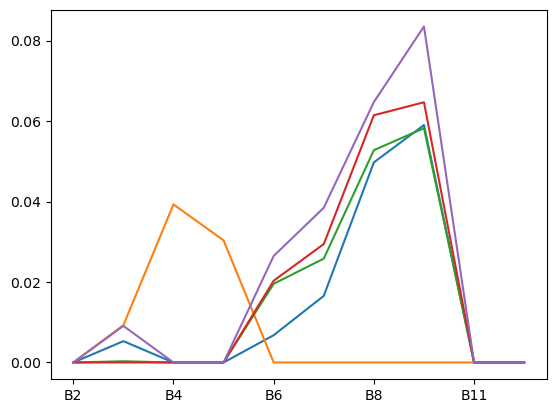

In [20]:
sampled_cr10 = continuum_removed(spectra)

for i in range (0,5,1):
    sampled_cr10.iloc[i,:].plot()
    

## log(1/R) Transformation

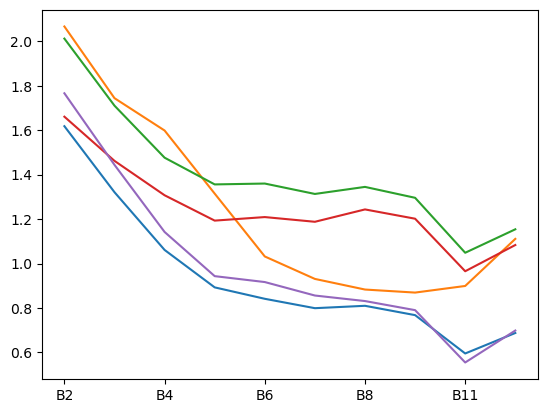

In [21]:
sampled_log10 = ((1/spectra).apply(np.log)).copy()
#log_spec.head(5)

for i in range (0,5,1):
    sampled_log10.iloc[i,:].plot()   

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec)

In [22]:
#sampled_spec10 = spectra.copy()

In [23]:
# for i in range (0,5,1):
#     sampled_spec[50].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [24]:
# sampled_cr = {}
# for n in nbands_sampling:
#     sampled_cr[n] = resample_spectra (cr_spec, n)

In [25]:
# for i in range (0,5,1):
#     sampled_cr[50].iloc[i,:].plot()

### 3. Sampled Log (sampled_log)

In [26]:
# sampled_log = {}
# for n in nbands_sampling:
#     sampled_log[n] = resample_spectra (log_spec, n)

In [27]:
# for i in range (0,10,1):
#     sampled_log[50].iloc[i,:].plot()

### 4.  FOD of sampled spectra (fod_sampled)

In [28]:
fod_sampled10 = fod (spectra)

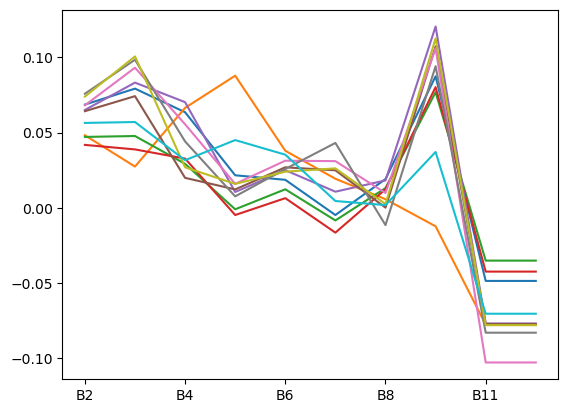

In [29]:
for i in range (0,10,1):
    fod_sampled10.iloc[i,:].plot()

### 5. FOD of sampled_cr10 (fod_cr10)

In [30]:
fod_cr10 = fod (sampled_cr10)

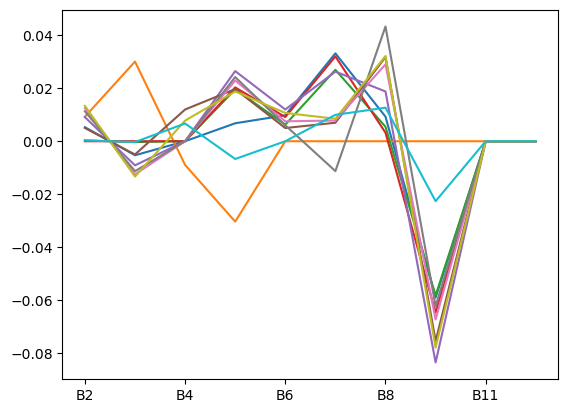

In [31]:
for i in range (0,10,1):
    fod_cr10.iloc[i,:].plot()

### 6. FOD of sampled_log10 (fod_log10)

In [32]:
fod_log10 = fod (sampled_log10)


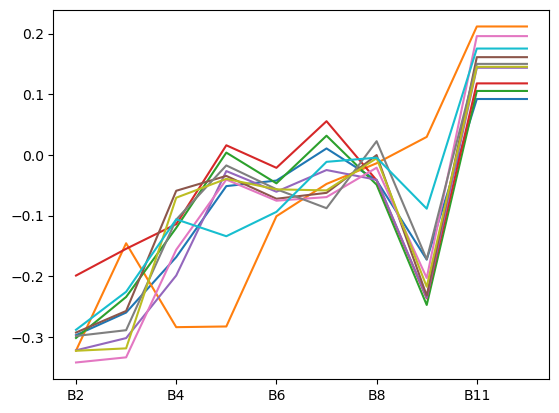

In [33]:
for i in range (0,10,1):
    fod_log10.iloc[i,:].plot()
    

## Visualizing Processed Spectrum (variable samples)

In [34]:
(row, col) = spectra.shape
(row, col)

(209, 10)

In [35]:
def plot_spec (sample, process):
    (row, col) = spectra.shape
    x1 = spectra.iloc[sample,:]
    x1.plot()
    if process == 'cr':
        x2 = sampled_cr10.iloc[sample,:]
        x2.plot()
    elif process == 'log':
        x3 = sampled_log10.iloc[sample,:]/3
        x3.plot()
    else:
        x4 = fod_sampled10.iloc[sample,:]*100
        x4.plot()
        
    plt.ylim([-5, 5])
    
(row, col) = spectra.shape
ipywidgets.interact(plot_spec, sample = (0, row, 1), process = prepare_spec)

interactive(children=(IntSlider(value=104, description='sample', max=209), Dropdown(description='process', opt…

<function __main__.plot_spec(sample, process)>

## Correlation between wavelengths and Targets

In [36]:
def find_rpval (spectra, tar):
    (r, c) = spectra.shape
    
    r_val = spectra.iloc[[0], :].copy()
    p_val = spectra.iloc[[0], :].copy()
    
    for j in range(0, c):
        r_val.iloc[0,j], p_val.iloc[0,j] = stats.pearsonr(tar, spectra.iloc[:, j])
    
    return(r_val, p_val)


In [37]:
# plt.style.use(['science','notebook','grid'])

# def plot_corr (target, prepare, n_bands):
    
#     i = target_names.index(target)    
    
#     if  prepare == 'none':
#         r_val, p_val = find_rpval (sampled_spec[n_bands], T[i])
#         r_val.iloc[0,:].plot(color = clr[i])
#     elif  prepare == 'cr':
#         r_cr, p_cr = find_rpval (sampled_cr[n_bands], T[i])
#         r_cr.iloc[0,:].plot(color = clr[i])
#     elif prepare == 'log':
#         r_log, p_log = find_rpval (sampled_log[n_bands], T[i])
#         r_log.iloc[0,:].plot(color = clr[i])
#     else:    
#         r_fod, p_fod = find_rpval (fod_sampled[n_bands], T[i])
#         r_fod.iloc[0,:].plot(color = clr[i]) 
    
#     plt.ylim([-0.9, 0.9])


# ipywidgets.interact(plot_corr, target = target_names, prepare = prepare_spec, n_bands = nbands_sampling)



# Step 2:  Parameters for Best Train-Test Split  

In [38]:
# tst_siz = 0.20

# rand_t = [None] * (len(T))
# err_t = [None] * (len(T))

# print('Without Normalization:')
# for i in range (0,len(T)):
#     rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
#     print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
# # rand_nt = [None] * (len(T))
# # err_nt = [None] * (len(T))

# # print('After Normalization:')
# # for i in range (0,len(T)):
# #     rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
# #     print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

In [39]:
Data = {'spectra' : spectra, 'T' : T,  'sampled_cr10' : sampled_cr10,  \
         'sampled_log10' : sampled_log10, 'fod_sampled10' : fod_sampled10, 'fod_cr10' : fod_cr10, 'fod_log10' : fod_log10}

In [40]:
with open ('data.pickle', 'wb') as file:
    pickle.dump(Data, file)

In [41]:
Data['T']

[0       98.0
 1      100.0
 2       71.0
 3       74.0
 4       94.0
        ...  
 204     98.0
 205     91.0
 206     95.0
 207     96.0
 208     89.0
 Name: Sand, Length: 209, dtype: float64,
 0      1.0
 1      0.0
 2      2.0
 3      1.0
 4      1.0
       ... 
 204    2.0
 205    1.0
 206    1.0
 207    3.0
 208    6.0
 Name: Silt, Length: 209, dtype: float64,
 0      0
 1      0
 2      7
 3      0
 4      0
       ..
 204    0
 205    0
 206    0
 207    0
 208    0
 Name: Clay, Length: 209, dtype: int64,
 0      0.22
 1      0.23
 2      0.54
 3      0.06
 4      5.97
        ... 
 204    0.29
 205    0.64
 206    1.64
 207    1.58
 208    1.66
 Name: TOC, Length: 209, dtype: float64]